In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
OPTA_FILEPATH = 'data/opta/ratings_2025-11-03.xlsx'
ELO_FILEPATH = 'data/elo/20251103.csv'
MAPPING_FILEPATH = 'teams_mapping/team_names.xlsx'

In [3]:
COUNTRY_DICT = {
    'England': 'ENG',
    'Poland': 'POL',
    'Portugal': 'POR',
    'Spain': 'ESP',
}

In [4]:
opta_dfs = pd.read_excel(OPTA_FILEPATH, sheet_name=None)

In [5]:
opta_df = pd.DataFrame()

for sheet_name, df in opta_dfs.items():
    df['Country'] = sheet_name
    opta_df = pd.concat([opta_df, df], ignore_index=True)

opta_df = opta_df[['Team', 'Rating', 'Country']]
opta_df.sort_values(by='Rating', ascending=False, inplace=True)
opta_df.reset_index(drop=True, inplace=True)
opta_df['Country_Code'] = opta_df['Country'].map(COUNTRY_DICT)
print(opta_df.shape)
opta_df.head()

(154, 4)


,Team,Rating,Country,Country_Code
0,Arsenal,100.0,England,ENG
1,Manchester City,97.5,England,ENG
2,Liverpool,97.0,England,ENG
3,Real Madrid,95.6,Spain,ESP
4,Barcelona,95.1,Spain,ESP


In [6]:
opta_country_codes = opta_df['Country_Code'].unique().tolist()
sorted(opta_country_codes)

['ENG', 'ESP', 'POL', 'POR']

In [7]:
elo_df = pd.read_csv(ELO_FILEPATH)

In [8]:
elo_df = elo_df[elo_df['Country'].isin(opta_country_codes)]
elo_df['Elo'] = elo_df['Elo'].apply(lambda x: round(x, 2))
elo_df.drop(columns=['Rank'], inplace=True)
elo_df.reset_index(drop=True, inplace=True)

print(elo_df.shape)
elo_df.head()

(122, 4)


,Club,Country,Level,Elo
0,Arsenal,ENG,1,2032.83
1,Liverpool,ENG,1,1974.46
2,Man City,ENG,1,1969.44
3,Real Madrid,ESP,1,1953.28
4,Barcelona,ESP,1,1927.42


In [9]:
map_df = pd.read_excel(MAPPING_FILEPATH)

In [10]:
map_df = map_df[['ELO_name', 'Opta_name']]
map_df.dropna(subset=['ELO_name'], inplace=True)
print(map_df.shape)
map_df.head()

(160, 2)


,ELO_name,Opta_name
24,Arsenal,Arsenal
25,Aston Villa,Aston Villa
26,Birmingham,Birmingham City
27,Blackburn,Blackburn Rovers
28,Bournemouth,AFC Bournemouth


In [11]:
# Find unmatched ELO clubs

elo_matched_df = pd.merge(elo_df, map_df, left_on='Club', right_on='ELO_name', how='inner')
elo_unmatched_df = elo_df[~elo_df['Club'].isin(elo_matched_df['Club'])]
elo_unmatched_df.head(20)

,Club,Country,Level,Elo


In [12]:
# Find unmatched Opta clubs

opta_matched_df = pd.merge(opta_df, map_df, left_on='Team', right_on='Opta_name', how='inner')
opta_unmatched_df = opta_df[~opta_df['Team'].isin(opta_matched_df['Team'])]
opta_unmatched_df.head(10)

,Team,Rating,Country,Country_Code
75,Stockport County,76.6,England,ENG
111,Wisła Kraków,72.2,Poland,POL
113,Vizela,71.7,Portugal,POR
115,Boavista,70.6,Portugal,POR
116,Torreense,70.4,Portugal,POR
117,Chaves,70.3,Portugal,POR
118,União de Leiria,69.8,Portugal,POR
119,Marítimo,69.2,Portugal,POR
120,Farense,69.2,Portugal,POR
121,Benfica II,69.0,Portugal,POR


In [13]:
elo_matched_df.head()

,Club,Country,Level,Elo,ELO_name,Opta_name
0,Arsenal,ENG,1,2032.83,Arsenal,Arsenal
1,Liverpool,ENG,1,1974.46,Liverpool,Liverpool
2,Man City,ENG,1,1969.44,Man City,Manchester City
3,Real Madrid,ESP,1,1953.28,Real Madrid,Real Madrid
4,Barcelona,ESP,1,1927.42,Barcelona,Barcelona


In [14]:
merged_df = pd.merge(elo_matched_df, opta_df, left_on=['Country', 'Opta_name'], right_on=['Country_Code', 'Team'], how='inner')
merged_df = merged_df[['ELO_name', 'Opta_name', 'Country_Code', 'Level', 'Elo', 'Rating']]
print(merged_df.shape)
merged_df.head()

(113, 6)


,ELO_name,Opta_name,Country_Code,Level,Elo,Rating
0,Arsenal,Arsenal,ENG,1,2032.83,100.0
1,Liverpool,Liverpool,ENG,1,1974.46,97.0
2,Man City,Manchester City,ENG,1,1969.44,97.5
3,Real Madrid,Real Madrid,ESP,1,1953.28,95.6
4,Barcelona,Barcelona,ESP,1,1927.42,95.1


In [15]:
lr = LinearRegression()

X = merged_df['Rating']
y = merged_df['Elo']

lr.fit(X.values.reshape(-1, 1), y.values)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [16]:
lr.score(X.values.reshape(-1, 1), y.values)

0.9425884236070006

In [17]:
print(f'y = {lr.coef_[0]} * x + {lr.intercept_}')

y = 23.519217858429986 * x + -314.52204773354447


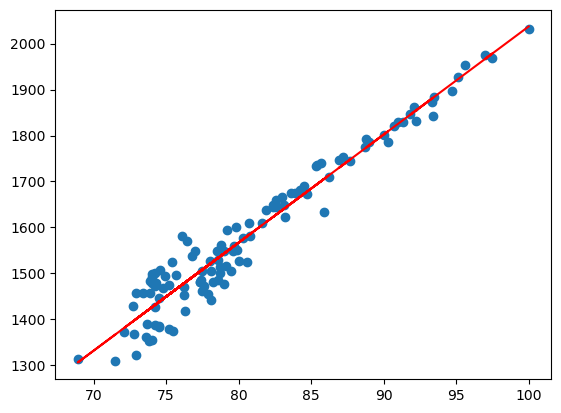

In [18]:
plt.scatter(X, y)
plt.plot(X, lr.predict(X.values.reshape(-1, 1)), color='red')

In [19]:
merged_df['predicted_Elo'] = lr.predict(X.values.reshape(-1, 1))
merged_df['predicted_Elo'] = merged_df['predicted_Elo'].apply(lambda x: round(x, 2))
merged_df['error'] = merged_df['Elo'] - merged_df['predicted_Elo']
merged_df['error'] = merged_df['error'].apply(round)
merged_df.head()

,ELO_name,Opta_name,Country_Code,Level,Elo,Rating,predicted_Elo,error
0,Arsenal,Arsenal,ENG,1,2032.83,100.0,2037.40,-5
1,Liverpool,Liverpool,ENG,1,1974.46,97.0,1966.84,8
2,Man City,Manchester City,ENG,1,1969.44,97.5,1978.60,-9
3,Real Madrid,Real Madrid,ESP,1,1953.28,95.6,1933.92,19
4,Barcelona,Barcelona,ESP,1,1927.42,95.1,1922.16,5


In [20]:
merged_df.tail()

,ELO_name,Opta_name,Country_Code,Level,Elo,Rating,predicted_Elo,error
108,Motor Lublin,Motor Lublin,POL,1,1354.84,74.0,1425.90,-71
109,Lechia,Lechia Gdańsk,POL,1,1352.45,73.8,1421.20,-69
110,Arka,Arka Gdynia,POL,1,1322.50,72.9,1400.03,-78
111,AVS Futebol,AVS,POR,1,1314.42,68.9,1305.95,8
112,Nieciecza,Nieciecza,POL,1,1309.81,71.5,1367.10,-57


In [21]:
merged_df.groupby(['Country_Code', 'Level'])['error'].median().reset_index()

,Country_Code,Level,error
0,ENG,1,1.5
1,ENG,2,-16.5
2,ESP,1,19.5
3,ESP,2,53.0
4,POL,1,-56.0
5,POR,1,-6.5
